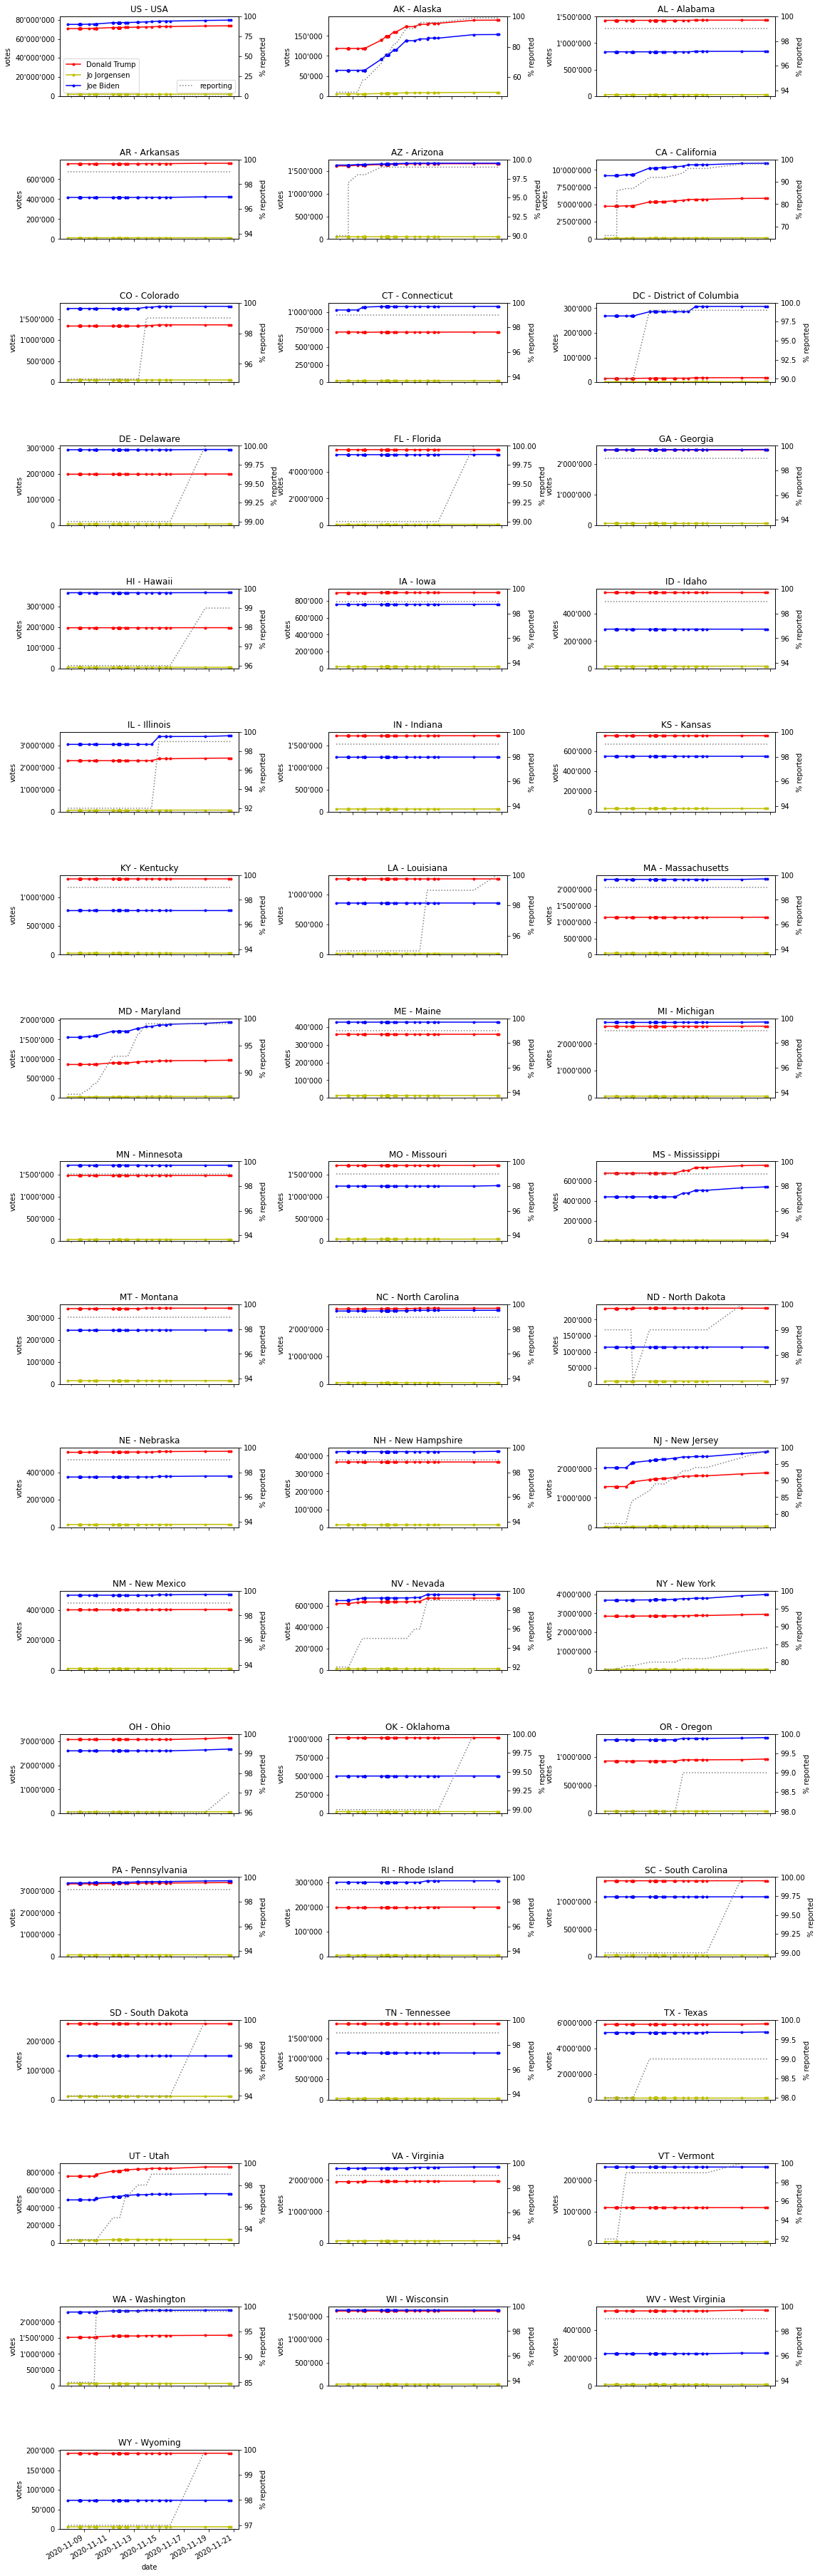

In [1]:
from glob import glob
import json
import datetime
import dateutil.parser
import pandas
import matplotlib
import matplotlib.pyplot as plt
import math
from cycler import cycler
#import locale
#locale.setlocale(locale.LC_ALL, '')

# gimme more width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:1500px !important; }</style>"))

NAME_BY_ACRONYM = {
    'US': 'USA',
    'AL': 'Alabama',        'AK': 'Alaska',        'AZ': 'Arizona',    'AR': 'Arkansas',             'CA': 'California',
    'CO': 'Colorado',       'CT': 'Connecticut',   'DE': 'Delaware',   'DC': 'District of Columbia', 'FL': 'Florida',
    'GA': 'Georgia',        'HI': 'Hawaii',        'ID': 'Idaho',      'IL': 'Illinois',             'IN': 'Indiana',
    'IA': 'Iowa',           'KS': 'Kansas',        'KY': 'Kentucky',   'LA': 'Louisiana',            'ME': 'Maine',
    'MD': 'Maryland',       'MA': 'Massachusetts', 'MI': 'Michigan',   'MN': 'Minnesota',            'MS': 'Mississippi',
    'MO': 'Missouri',       'MT': 'Montana',       'NE': 'Nebraska',   'NV': 'Nevada',               'NH': 'New Hampshire',
    'NJ': 'New Jersey',     'NM': 'New Mexico',    'NY': 'New York',   'NC': 'North Carolina',       'ND': 'North Dakota',
    'OH': 'Ohio',           'OK': 'Oklahoma',      'OR': 'Oregon',     'PA': 'Pennsylvania',         'RI': 'Rhode Island',
    'SC': 'South Carolina', 'SD': 'South Dakota',  'TN': 'Tennessee',  'TX': 'Texas',    'UT':       'Utah',
    'VT': 'Vermont',        'VA': 'Virginia',      'WA': 'Washington', 'WV': 'West Virginia',        'WI': 'Wisconsin',
    'WY': 'Wyoming',        'PR': 'Puerto Rico',
}

files = sorted(glob('*.json'))

with open(files[0]) as f: data = json.load(f)
states = ['US'] + sorted(set(data.keys()) - set(['US']))  # let US be first

COLS = 3
ROWS = math.ceil(len(states)/COLS)

int_formatter = lambda x: format(int(x), ',d').replace(',', "'")

# subplots style
fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS*6, ROWS*4))
plt.subplots_adjust(wspace=0.5, hspace=0.8)
ticker_formatter = matplotlib.ticker.FuncFormatter(lambda x, p: int_formatter(x))
plt.axis('off')

# hide subplots by default
for i in axes:
    for j in i: j.set_axis_off()

def load_data():
    raw_data = []
    for file in files:
        with open(file) as f: data = json.load(f)
        dt = file.split('--')[-1].rsplit('.', 4)[0].replace('.', ':')
        ts = dateutil.parser.isoparse(dt)
        raw_data.append((ts, data))
    return raw_data

def plot_state(raw_data, ax1, state, show_legend=True, y_starts_at_zero=True):
    votes_items = []
    infos_items = []
    names = set()
    # iterate over all dates
    for ts, data_allstates in raw_data:
        data = data_allstates[state]

        # collect votes
        scores = {candidate['name']:candidate['votes'] for candidate in data['candidates']}
        uncounted = 1
        item = {'date': ts}
        for name,votes in sorted(scores.items()):
            item[name] = votes
            names.add(name)
        votes_items.append(item)

        # collect other infos
        item = {'date': ts, 'reporting': data['reporting']}
        infos_items.append(item)

    # plot this state
    ax1.set_axis_on()

    # - add votes
    ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.get_yaxis().set_major_formatter(ticker_formatter)
    df1 = pandas.DataFrame(votes_items)
    df1.plot(x='date', y=sorted(names),
             style='.-',
             title=f'{state} - {NAME_BY_ACRONYM[state]}',
             ylabel='votes',
             ylim=(0 , None) if y_starts_at_zero else None,
             color=['r', 'y', 'b'],
             ax=ax1)
    ax1.legend(loc='lower left')

    # - add % reported
    ax2 = ax1.twinx()
    df2 = pandas.DataFrame(infos_items)
    df2.plot(x='date', style=':',
             ylabel='% reported',
             color='tab:grey',
             ylim=(None, 100),
             ax=ax2)
    ax2.legend(loc='lower right')

    # - keep legends only on 1st subplot
    if not show_legend:
        ax1.get_legend().remove()
        ax2.get_legend().remove()

    # Bug: x labels vanish: https://github.com/pandas-dev/pandas/issues/27812

raw_data = load_data()
for i, state in enumerate(states):
    col = i % COLS
    row = i // COLS
    ax1 = axes[row, col]
    plot_state(raw_data, ax1, state, show_legend=i==0, y_starts_at_zero=True)

In [2]:
# https://stackoverflow.com/a/62853540
import plotly.express as px
from plotly.subplots import make_subplots

# https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6
from ipywidgets import interact, interact_manual


def make_state_df(state):
    dates = []
    votes_by_candidate = {}
    reporting = []
    names = set()
    # iterate over all dates
    for ts, data_allstates in raw_data:
        data = data_allstates[state]

        # collect votes
        for candidate in data['candidates']:
            name, votes = candidate['name'], candidate['votes']
            names.add(name)
            votes_by_candidate.setdefault(name, []).append(votes)
        
        dates.append(ts)
        reporting.append(data['reporting'] / 100.)

    df = pandas.DataFrame()
    df['date'] = dates
    for name in names:
        df[name] = votes_by_candidate[name]
    df.set_index('date', inplace=True)

    df2 = pandas.DataFrame()
    df2['date'] = dates
    df2['reporting'] = reporting
    df2.set_index('date', inplace=True)

    return df, df2

def plot_state(state):
    votes, reporting = make_state_df(state)
    no_reporting = reporting['reporting'][-1] == 0.0
    
    subfig = make_subplots(specs=[[{'secondary_y': True}]])
    subfig.layout.title = NAME_BY_ACRONYM[state]

    fig1 = px.scatter(votes,
                  color_discrete_sequence=['red', 'yellow', 'blue'],
                  render_mode='webgl').update_traces(mode='lines+markers')

    if not no_reporting:
        # create two independent figures
        fig2 = px.line(reporting,
                       color_discrete_sequence=['lightgray'],
                       line_dash_sequence=['dot'],
                       render_mode='webgl')
        fig2.update_traces(yaxis='y2')

        subfig.add_traces(fig2.data)

    subfig.add_traces(fig1.data)
    subfig.layout.xaxis.title = 'Date'
    subfig.layout.yaxis.title = 'Votes'
    subfig.layout.yaxis.tickformat = 'n'

    if not no_reporting:
        subfig.layout.yaxis2.title = 'Reported'
        subfig.layout.yaxis2.tickformat = '%'
        subfig.layout.yaxis2.showgrid = False

    subfig.show()

ACRONYM_BY_STATE = {f'{NAME_BY_ACRONYM[state]} ({state})':state for state in states}

@interact
def plot_selected_state(name=ACRONYM_BY_STATE.keys()):
    plot_state(ACRONYM_BY_STATE[name])


interactive(children=(Dropdown(description='name', options=('USA (US)', 'Alaska (AK)', 'Alabama (AL)', 'Arkans…